In [1]:
from transformers import BertTokenizer, AutoConfig, AutoModelForSequenceClassification, AutoModelForMaskedLM, AutoTokenizer

config = AutoConfig.from_pretrained('vinai/bertweet-base')
tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
model = AutoModelForSequenceClassification.from_pretrained("./after-bert-random-trainer/checkpoint-50000", num_labels=2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1    100685
0     36135
Name: label, dtype: int64


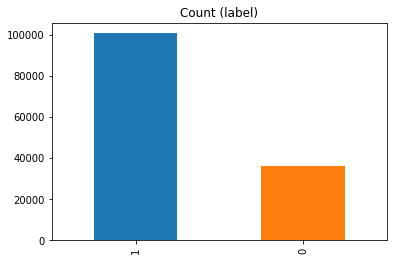

In [3]:

from glob import glob
from datasets import Dataset

import re
import pandas as pd

from parse import data_loading

data_url = '../crawler/stock/data/**.json'
url = glob(data_url)[-1]
data = data_loading(url, is_under_sampling=False)

print(data['label'].value_counts())
data['label'].value_counts().plot(kind='bar', title='Count (label)', color=['#1f77b4', '#ff7f0e'])

dataset = Dataset.from_pandas(data.loc[:, ['label', 'sentense']])
dataset = dataset.remove_columns('__index_level_0__')


dataset = dataset.train_test_split(test_size=0.2)

train_dataset = dataset['train']
test_dataset = dataset['test']

In [2]:
import pandas as pd
from glob import glob

def data_loading(url):
    with open(url, 'r', encoding='utf-8') as f:
        # data = json.loads(f.read())
        df = pd.read_json(f)
        data = df.copy()
        # data = df.loc[:, ['sentiment', 'body']]
        data = data.loc[df['sentiment'].notnull()]
        data['sentiment'] = pd.Categorical(data['sentiment'])
        data['label'] = data['sentiment'].cat.codes
        data = data.rename(columns={'sentiment': 'labels', 'body': 'sentense'})

        symbols = set()
        for symbol_list in data['sentense'].str.findall(r'\$[A-Z]+'):
            for symbol in symbol_list:
                symbols.add(symbol)
        return data, symbols


data_url = '../crawler/stock/data/**.json'
url = glob(data_url)[-1]
data, symbols = data_loading(url)
special_tokens_dict = {'additional_special_tokens': list(symbols)}
tokenizer.add_special_tokens(special_tokens_dict)

100

In [33]:
data.loc[data['sentense'].str.find('http') != -1].head()

,message_id,sentense,labels,created_at,label
17,447646810,$ETH.X $AAPL $CAPR \n \n$1800 into $54k in th...,Bullish,2022-03-28 13:41:04+00:00,1
37,447639081,$NVDA Small and big investors! this boat about...,Bullish,2022-03-28 13:21:18+00:00,1
39,447636617,$CODX $AGRX $SHOP $AMD $NVDA https://finance.y...,Bullish,2022-03-28 13:13:13+00:00,1
45,447633466,$AMD - $NVDA \n\nhttps://stocktwits.com/jantho...,Bullish,2022-03-28 13:02:56+00:00,1
70,447633241,$PLTR $MSFT $AMZN $GOOGL $QQQ \n\nhttps://clou...,Bullish,2022-03-28 13:02:13+00:00,1


In [47]:
import re
from parse import normalizeTweet
sentense = data.loc[37]['sentense']

s = re.split(r'(\$[A-Z]+)', sentense)
a = [tokenizer.normalizeTweet(i) if i.find('$') == -1 else i for i in s]
new_s = " ".join(a)

print(tokenizer.normalizeTweet('<mask> to the sky !!!'))

# print(sentense)
# print(tokenizer.encode(sentense))
# print(tokenizer.normalizeTweet(sentense))
# print(tokenizer(sentense))
# print(normalizeTweet(sentense, tokenizer))
# print(tokenizer.encode(tokenizer.normalizeTweet(sentense)))

<mask> to the sky ! ! !


In [44]:
tokenizer.convert_ids_to_tokens(55350)

'AMZN'

In [6]:
import wandb
api = wandb.Api()
run = api.run("Stocktwit_sentiment_analysis/")
# run.delete()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29625, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [2]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element